## Load modules

In [64]:
%matplotlib notebook
from audio_split import split
from google_speech import transcribe
from utils import *

from IPython.display import HTML

import os
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from spacy import displacy

from sklearn.manifold import TSNE

from collections import Counter
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_colwidth', -1)

## Split audio files
We downloaded the audio file from a YouTube video and converted it to a mono-channel WAV file.

Then we split the file into smaller files, each of which is not longer 50 seconds.

In [3]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KHyLmb787MA?start=390" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/ubuntu/anaconda3/envs/hack4childmentalhealth/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [4]:
audio_file = '3yr_long_trimmed.wav'
split(args2obj(file=audio_file, batch=50), tqdm_func=tqdm)
audio_file_name, audio_file_ext = os.path.splitext(audio_file)
audio_split_files = sorted(glob.glob('{}_*{}'.format(audio_file_name, audio_file_ext)))
audio_split_files

['3yr_long_trimmed_0.wav',
 '3yr_long_trimmed_1.wav',
 '3yr_long_trimmed_2.wav',
 '3yr_long_trimmed_3.wav',
 '3yr_long_trimmed_4.wav',
 '3yr_long_trimmed_5.wav',
 '3yr_long_trimmed_6.wav',
 '3yr_long_trimmed_7.wav',
 '3yr_long_trimmed_8.wav',
 '3yr_long_trimmed_9.wav']

## Speech to Text Recognition
We use Google cloud's speech-to-text API to transcribe the audio files.

In [131]:
all_results = []
for file in tqdm(audio_split_files):
    out_file = '{}.jsonl'.format(os.path.splitext(file)[0])
    if os.path.exists(out_file):
        all_results.extend(json.loads(line) for line in open(out_file, 'r', encoding='utf8'))
    else:
        results = transcribe(args2obj(file=file, stream=False, sample_rate_hertz=None, num_speakers=1))
        with open(out_file, 'w', encoding='utf8') as fout:
            for result in results:
                data = dict(transcript=result.alternatives[0].transcript.strip(),
                            confidence=result.alternatives[0].confidence)
                all_results.append(data)
                fout.write(json.dumps(data, ensure_ascii=False) + os.linesep)
                
            
original_df = pd.DataFrame(all_results)
original_df.iloc[33:38]

,confidence,transcript
33,0.642340,Eva Braun
34,0.887016,this is a really good Brownwood
35,0.947125,brown Water next time you get brown water on you
36,0.903320,don't get round rubber on you okay don't get water Brown
37,0.913404,brown the water's not good to paint on you


We filter out those that have low confidens scores:

<IPython.core.display.Javascript object>


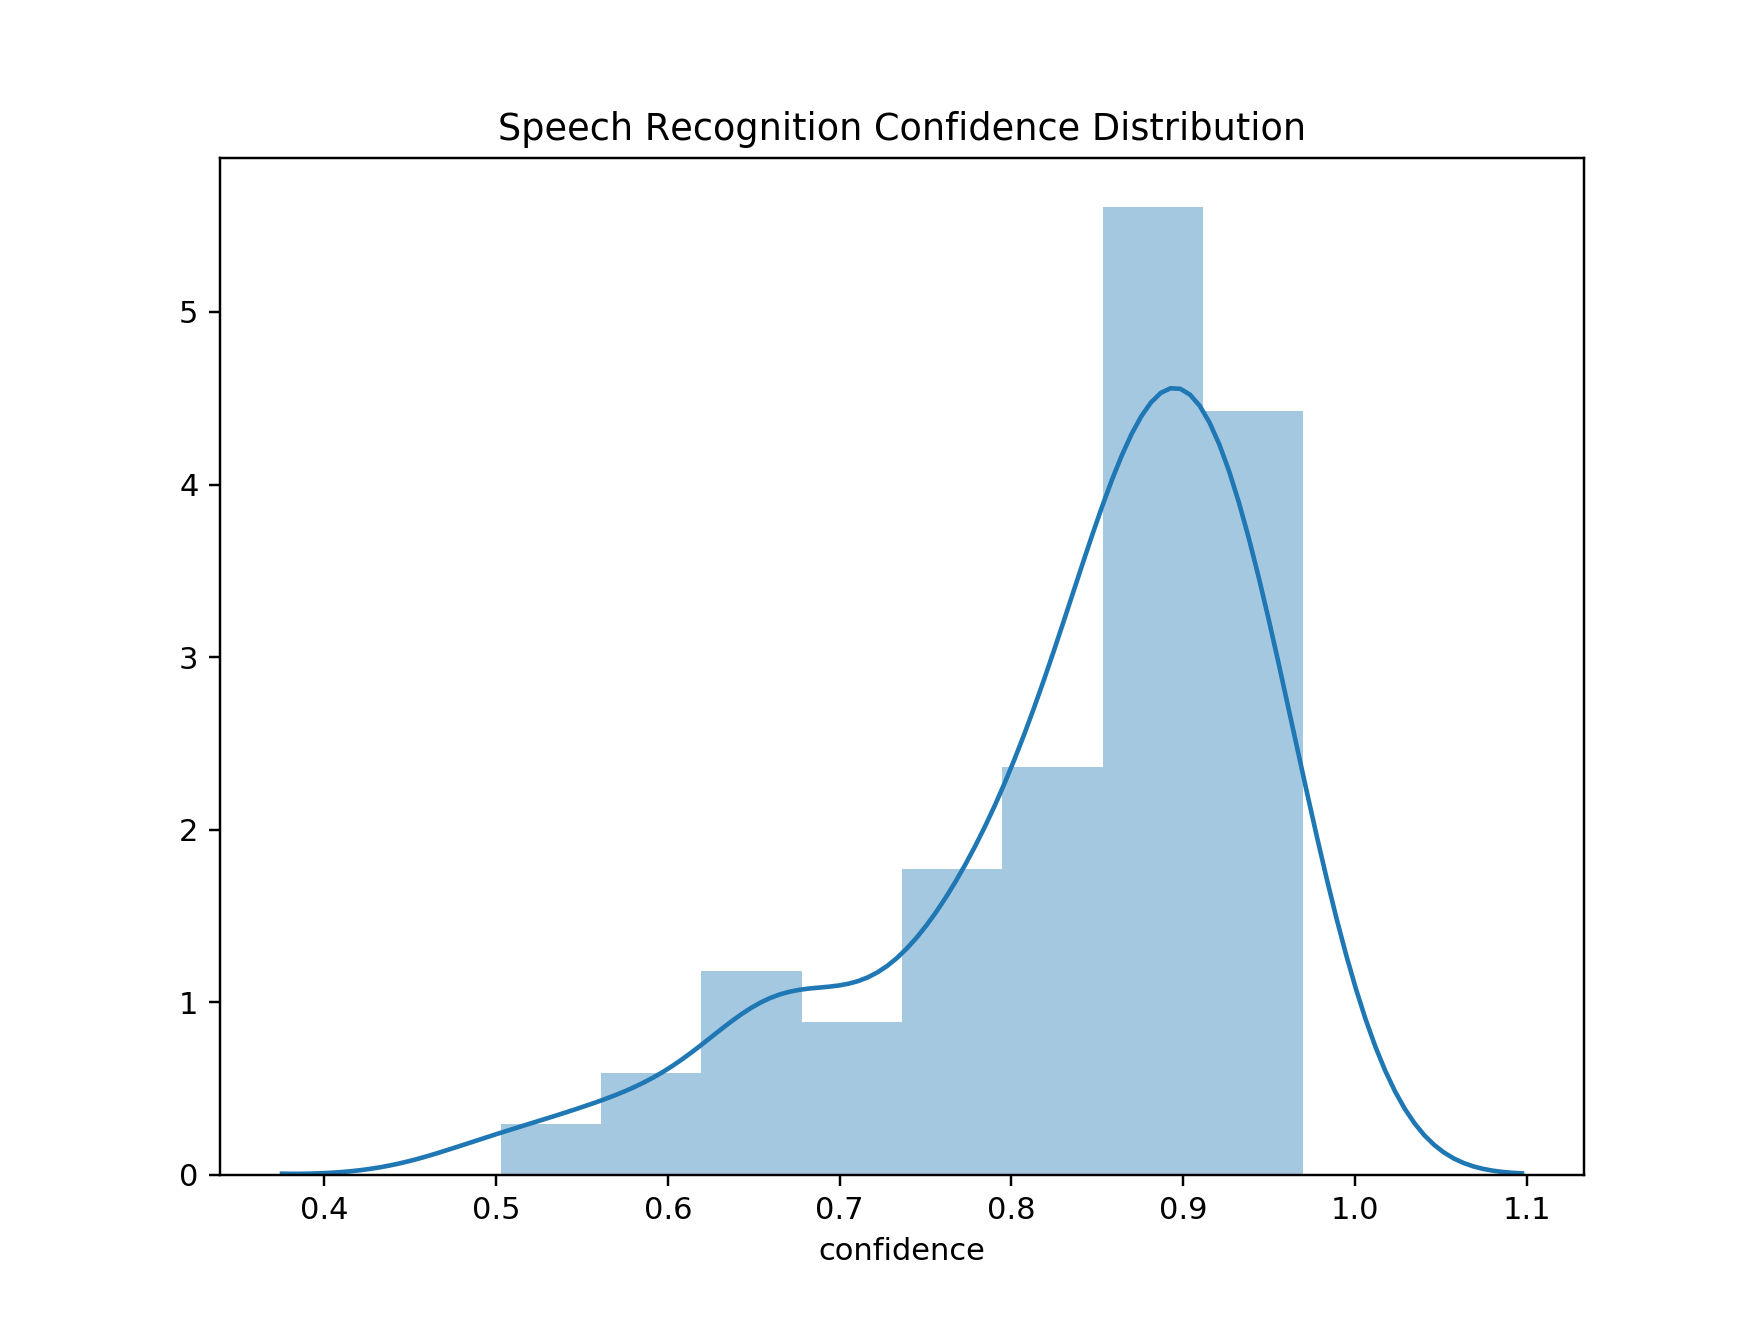

filtered out 9 , remaining 49


In [132]:
fig = sns.distplot(original_df.confidence).get_figure()
plt.title('Speech Recognition Confidence Distribution')
fig.set_size_inches(8, 6)
df = original_df[original_df.confidence > 0.7]
print('filtered out', len(original_df) - len(df), ', remaining', len(df))

## Analysis
We apply basic NLP techniques (e.g. tokenization, lemmatization, ngram extraction) to find key words and phrases.

### Word Frequencies
We find the top most frequent words and phrases here.

<IPython.core.display.Javascript object>


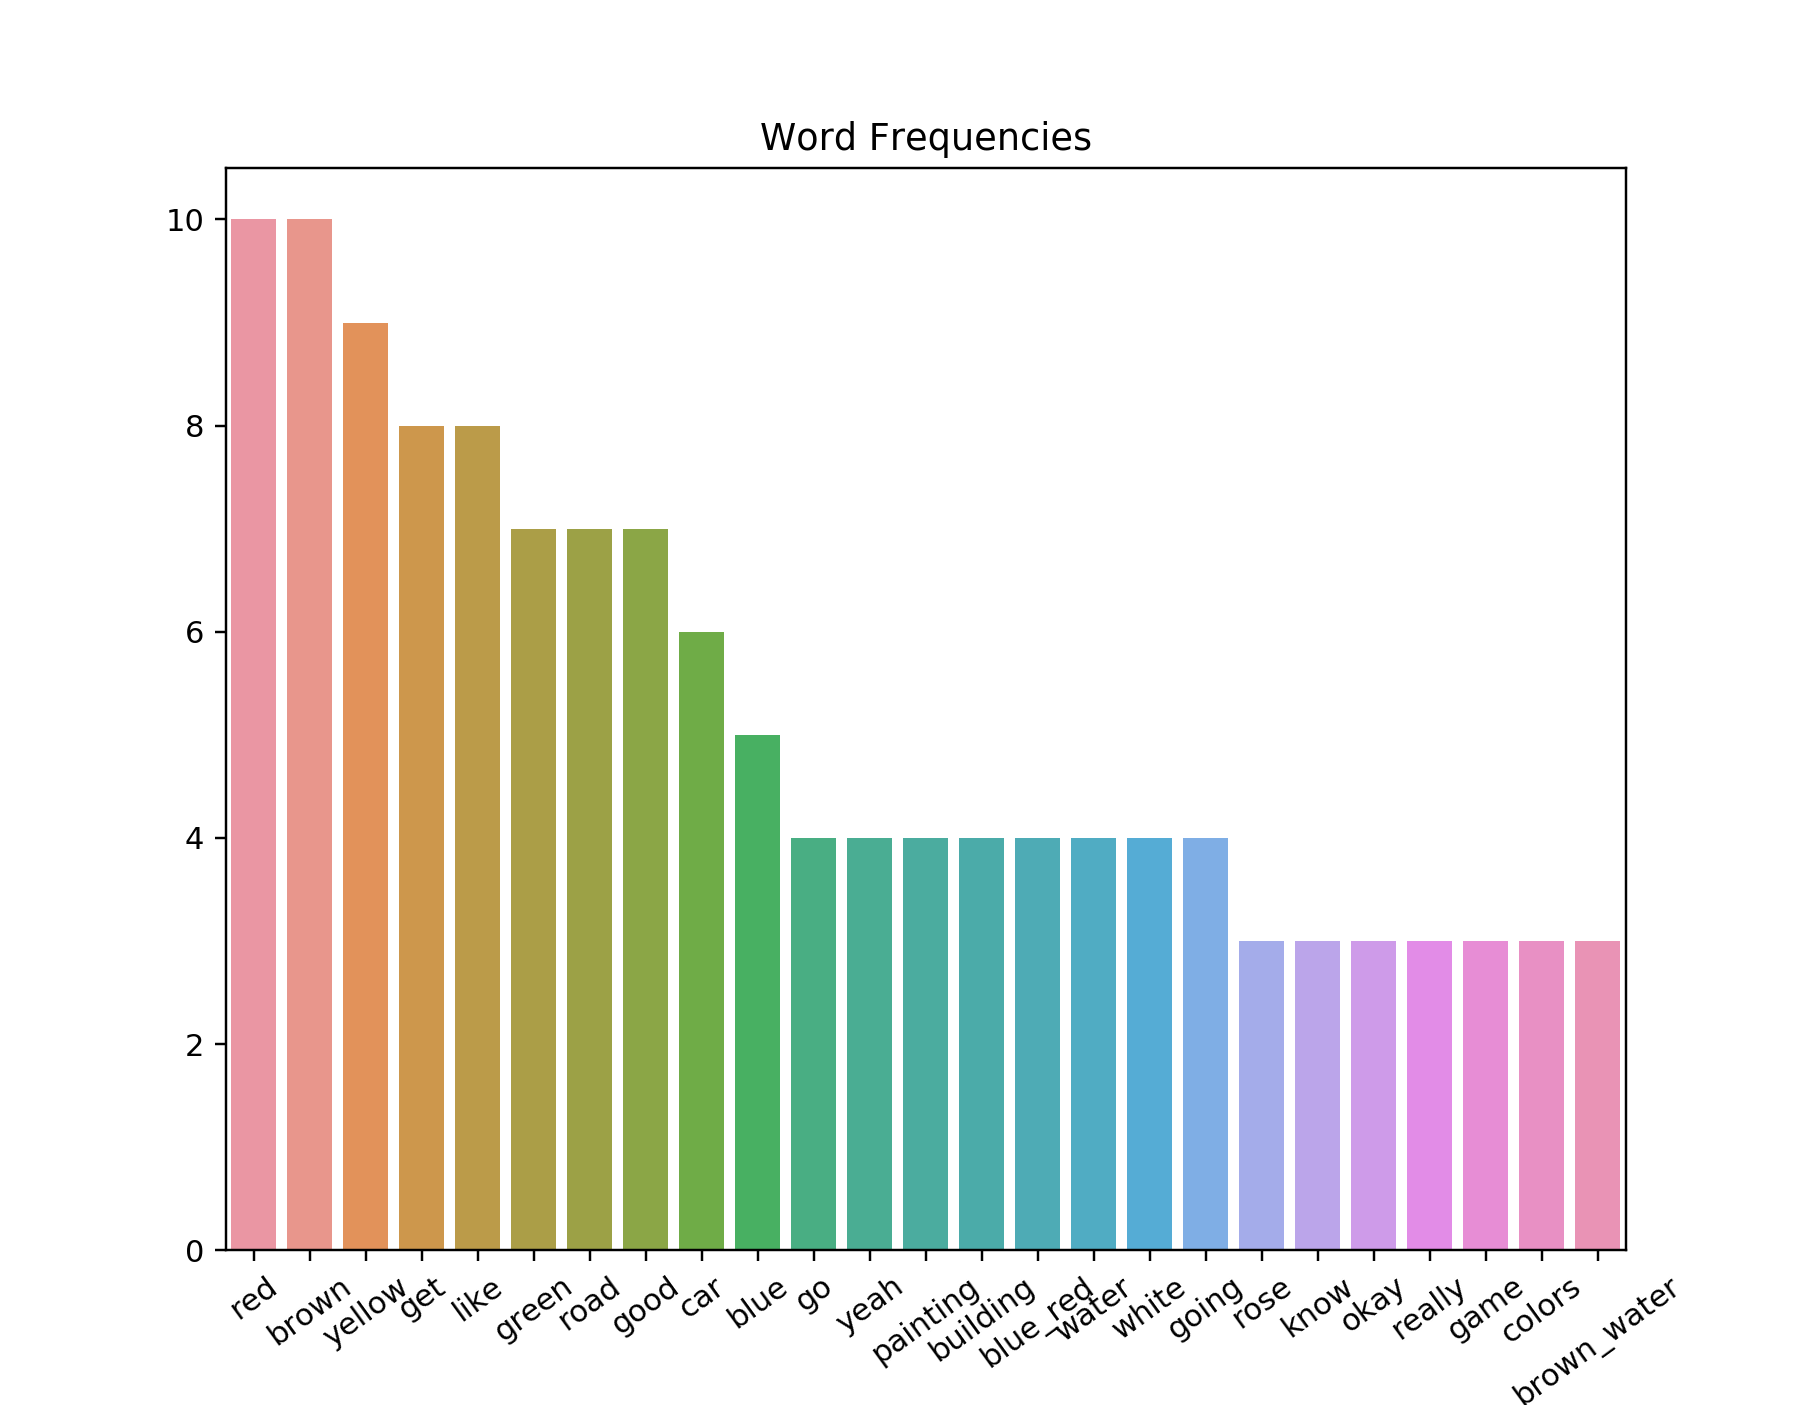

In [126]:
def get_freq(docs):
    return pd.DataFrame({'frequency': pd.Series(Counter((w for doc in docs for w in doc))).sort_values(ascending=False)})

documents, _ = process_documents(df.transcript)
filtered_documents = [[w for w in doc if w not in STOPWORDS] for doc in documents]
phrases = Phrases(filtered_documents, min_count=1, threshold=1)
bigrams = [phrases[doc] for doc in filtered_documents]

def pos_tags(s):
    return [(tok.text, tok.tag_, tok.pos_) for tok in SPACY_TAGGER(s)]

filtered_bigrams = []
for doc in bigrams:
    current_filtered_bigrams = []
    for word in doc:
        if '_' in word:
            tags = pos_tags(' '.join(word.split('_')))
            if tags[0][1] == 'JJ' and tags[1][1] == 'NN':
                current_filtered_bigrams.append(word)
    if current_filtered_bigrams:
        filtered_bigrams.append(current_filtered_bigrams)
      
joined_documents = filtered_documents + filtered_bigrams
terms = [w for doc in joined_documents for w in doc]
words_by_freq = get_freq(joined_documents)
fig = sns.barplot(data=words_by_freq.head(25).transpose()).get_figure()
plt.title('Word Frequencies')
plt.xticks(rotation=36)
fig.set_size_inches(8, 6)
fig.savefig('word_freq.png', dpi=256)

### Word Cloud
We can also apply word cloud to the key words and phrases:

In [76]:
from word_cloud.word_cloud_generator import WordCloud

lemmatized_input = [' '.join(doc) for doc in joined_documents]

wc = WordCloud(use_tfidf=False, stopwords=STOPWORDS)

embed_code = wc.get_embed_code(text=lemmatized_input,random_color=True,topn=50)

HTML(embed_code)

### Cluster Analysis
We embed words and phrases vector space and apply t-SNE for visualization.

<IPython.core.display.Javascript object>


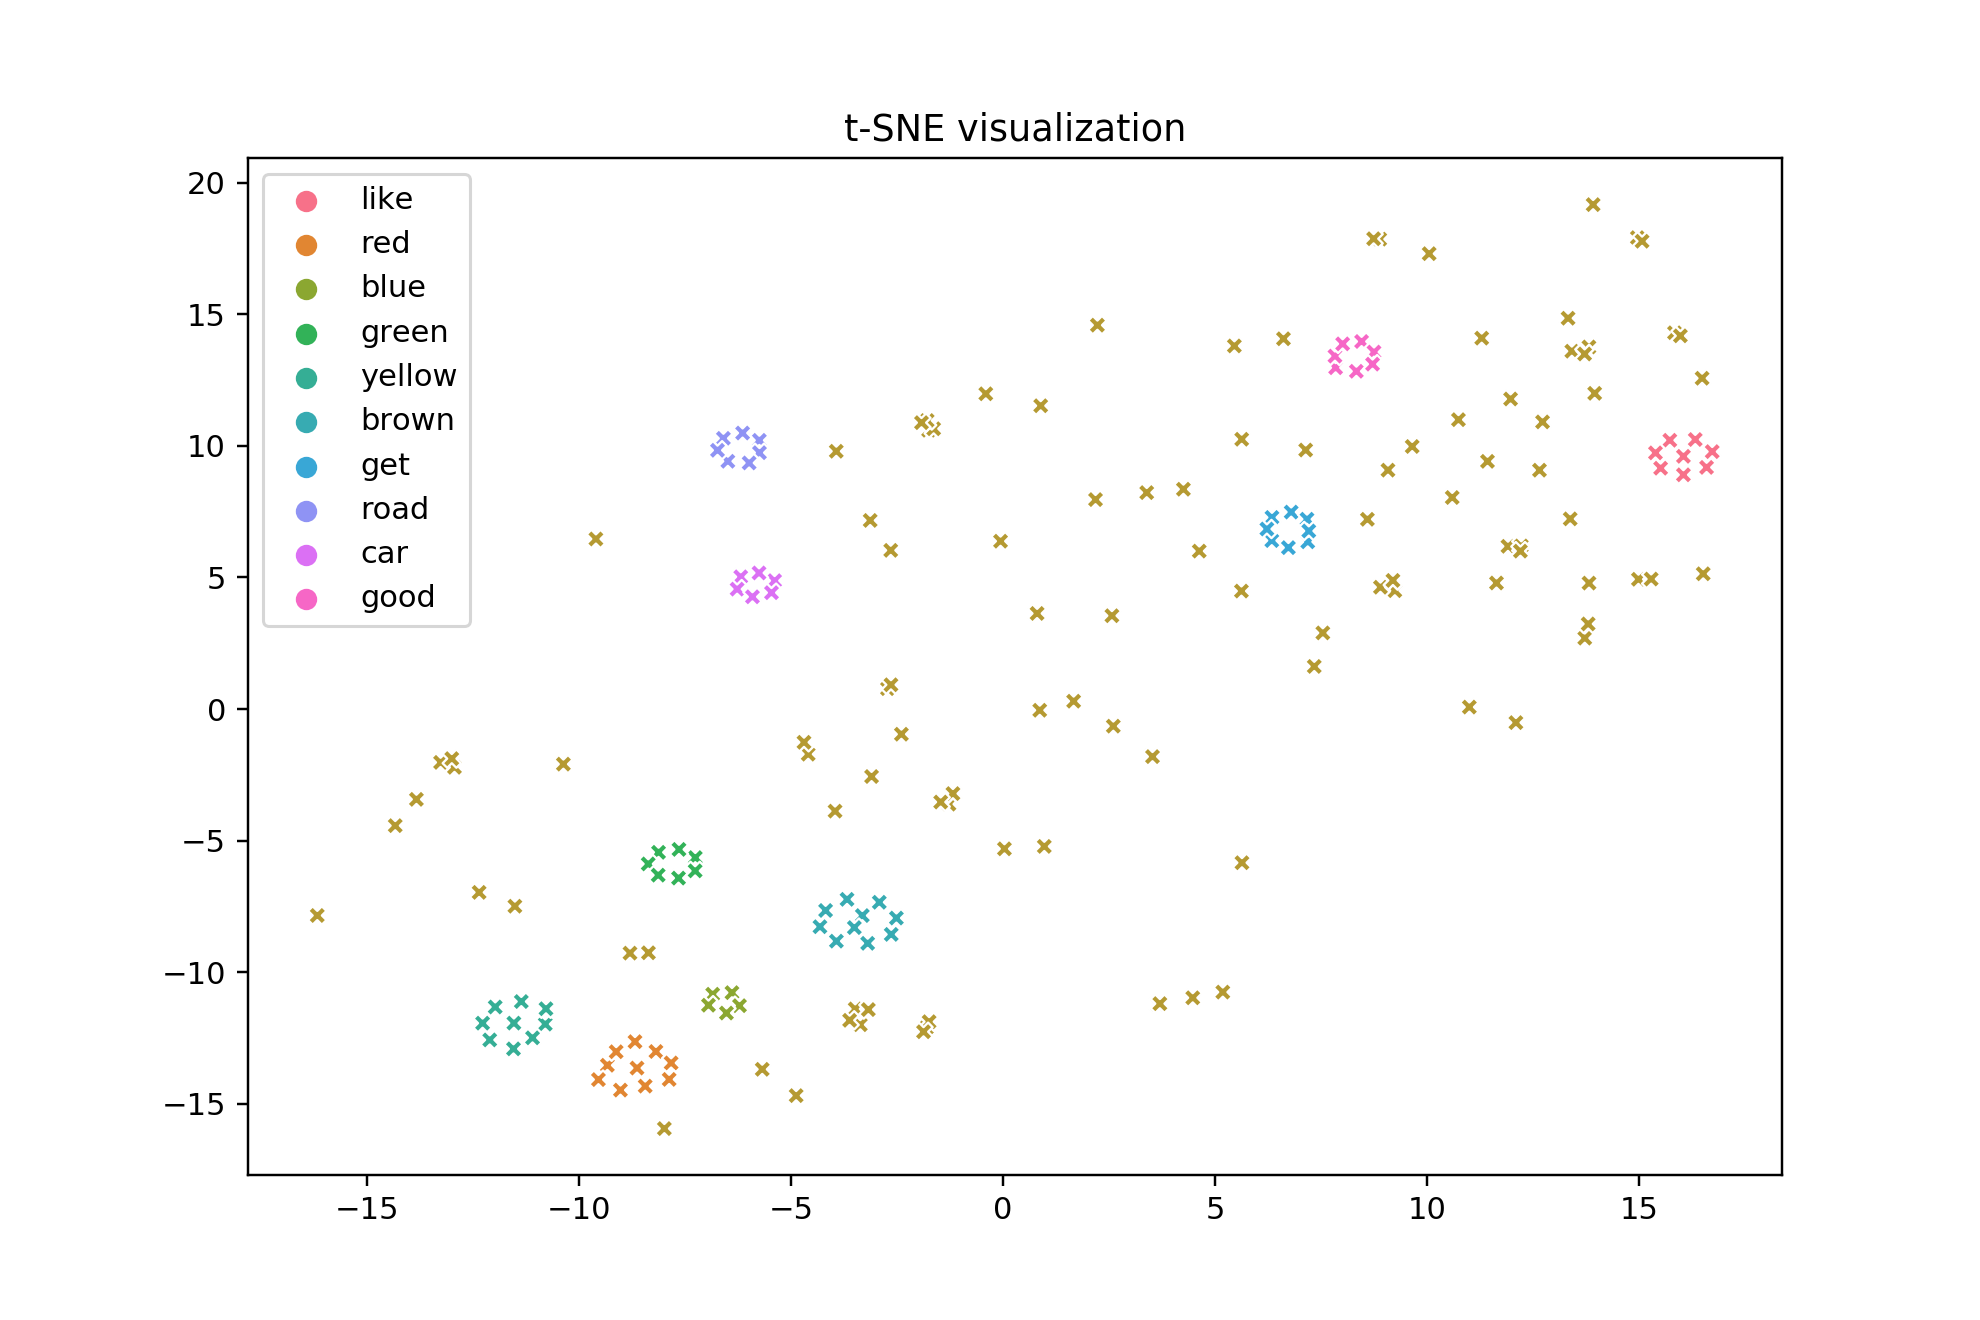

In [77]:
words_to_cluster = terms
X = VECS.query(words_to_cluster)
X_embedded = TSNE(n_components=2).fit_transform(X)

x = X_embedded[:, 0].squeeze()
y = X_embedded[:, 1].squeeze()
labels = ['' if word not in words_by_freq.index or words_by_freq.loc[word].frequency < 5 else word for word in words_to_cluster]
# print(labels)
fig = sns.scatterplot(x=x,
                y=y,
                hue=labels,
                style=labels if len(np.unique(labels)) <= 8 else None,
                marker='X',
                legend='brief').get_figure()

plt.title('t-SNE visualization')
fig.set_size_inches(9, 6)
fig.savefig('tsne.png', dpi=256)

### Part-of-Speech Tags Analysis

In [122]:
pos_tag_df = pd.DataFrame({
    'count': pd.Series(Counter((pos for tag_tuples in map(pos_tags, df.transcript) for _, tag, pos in tag_tuples))).sort_values(ascending=False),
})
pos_tag_df['description'] = [spacy.explain(label) for label in pos_tag_df.index] 
pos_tag_df

,count,description
VERB,89,verb
ADJ,62,adjective
NOUN,59,noun
PRON,48,pronoun
ADP,33,adposition
CCONJ,31,coordinating conjunction
DET,30,determiner
ADV,22,adverb
PROPN,19,proper noun
PART,13,particle


<IPython.core.display.Javascript object>


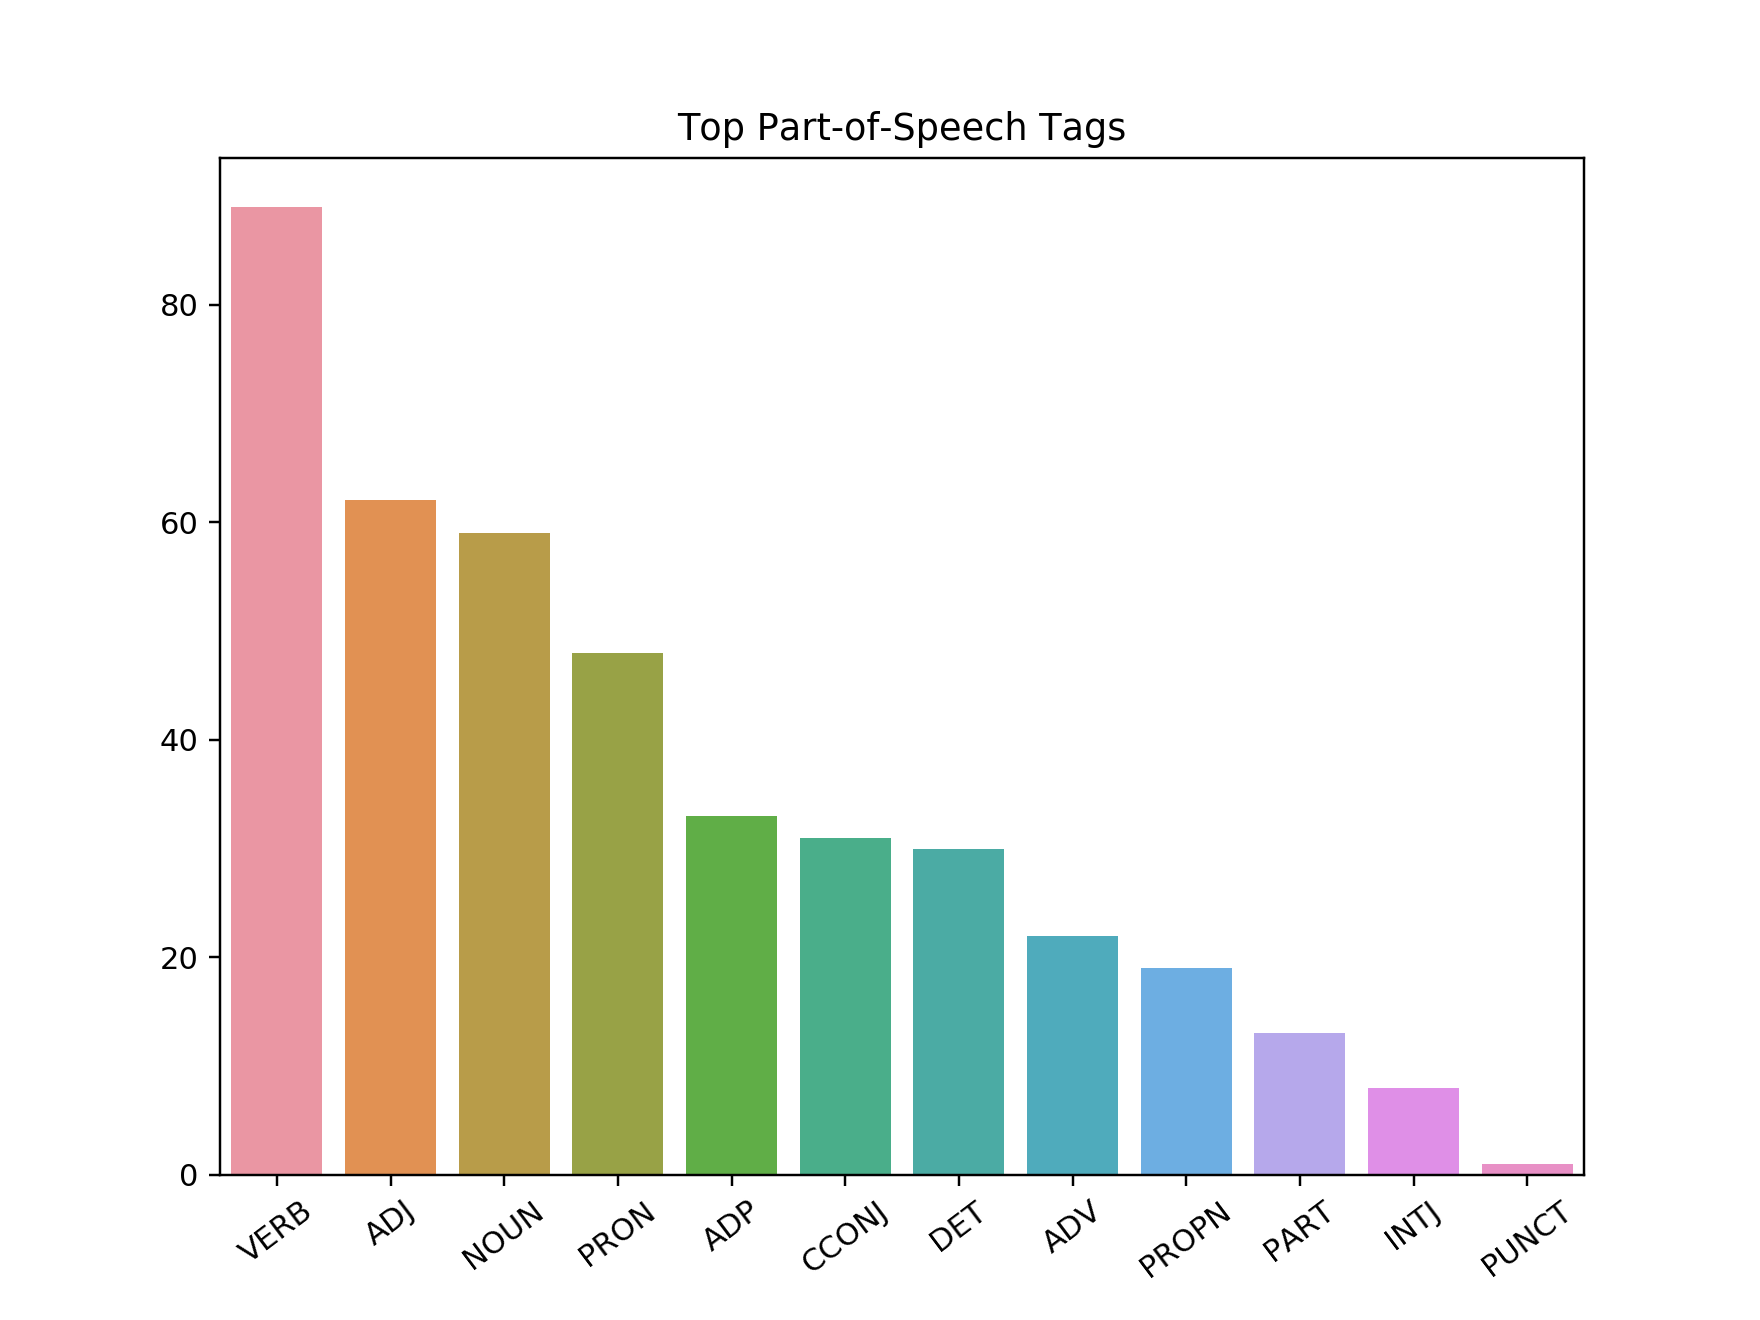

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

In [124]:
fig = sns.barplot(data=pos_tag_df[['count']].transpose()).get_figure()
plt.title('Top Part-of-Speech Tags')
fig.set_size_inches(8, 6)
plt.xticks(rotation=37)

<IPython.core.display.Javascript object>


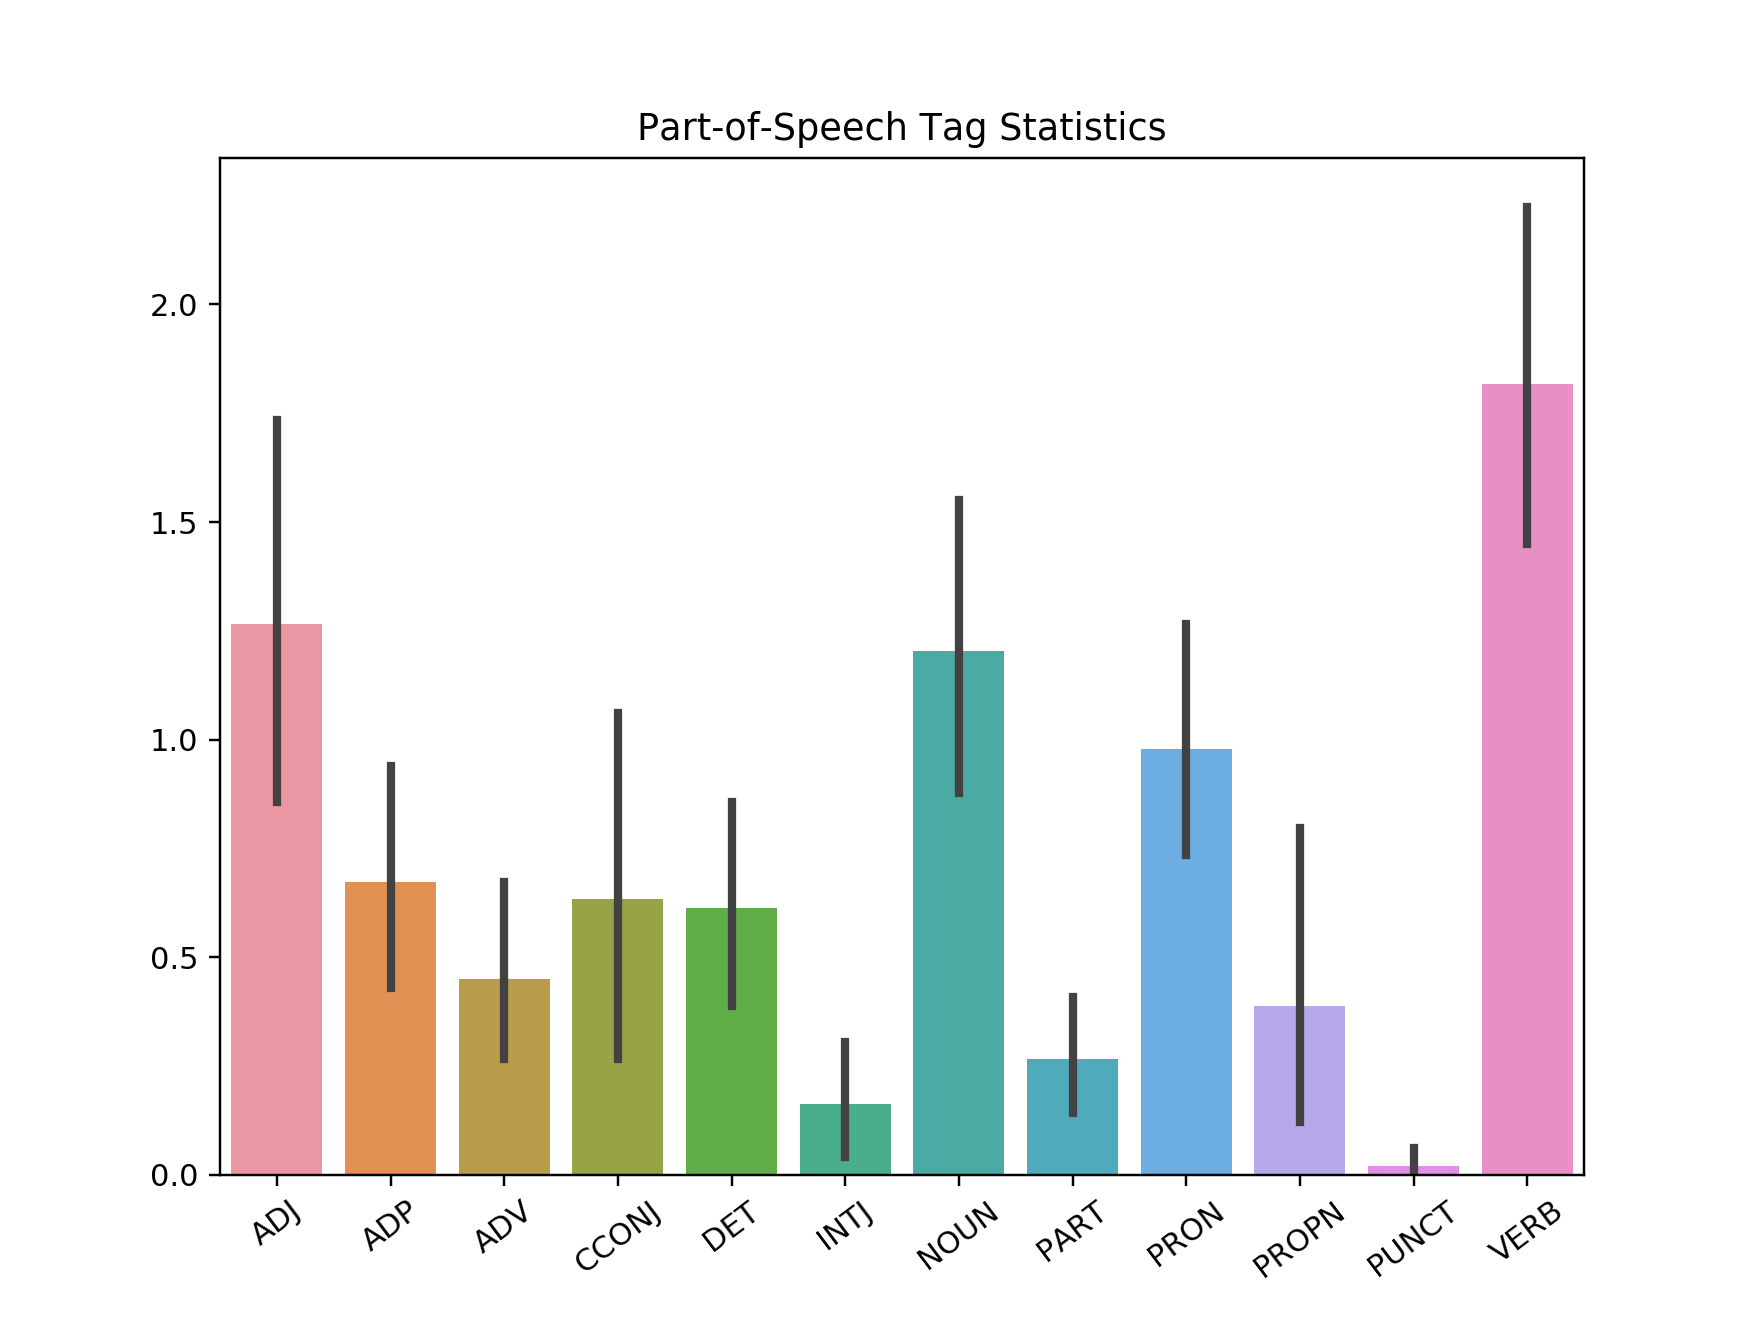

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

In [125]:
pos_tag_stats = pd.DataFrame([Counter(pos for _, tag, pos in pos_tags(text)) for text in df.transcript]).fillna(0)
fig = sns.barplot(data=pos_tag_stats).get_figure()
plt.title('Part-of-Speech Tag Statistics')
fig.set_size_inches(8, 6)
plt.xticks(rotation=37)

### Error analysis
What instances did the Google API recognize with low confidence?

In [13]:
original_df[original_df.confidence <= 0.7]

,confidence,transcript
2,0.502656,Rainy Night Nikki
5,0.684929,all the shoe show
9,0.658179,where can we make a girl
16,0.647586,the chill game
17,0.564375,I can draw a game
19,0.669746,a yellow bird
33,0.642340,Eva Braun
44,0.585578,that we need
54,0.687548,we're making building


### Named Entity Reconition
This is not fantastic because of transcription error from Google API.

In [55]:
ner = spacy.load("en_core_web_sm", disable=['tagger', 'parser'])
ents = []
for text in df.transcript:
    doc = ner(text)
    if doc.ents:
        ents.extend(doc.ents)
        displacy.render(ner(text), style='ent', jupyter=True)

In [67]:
ner_df = pd.DataFrame({'count': pd.Series(Counter(map(lambda ent: ent.label_, ents))).sort_values(ascending=False)})
ner_df['description'] = [spacy.explain(label) for label in ner_df.index] 
ner_df

,count,description
PERSON,4,"People, including fictional"
GPE,4,"Countries, cities, states"
ORG,2,"Companies, agencies, institutions, etc."
FAC,2,None
